# Importing Libraries

In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

## Club Researcher

In [2]:
from typing import Literal, Optional, TypedDict, Annotated, List
from operator import add

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool


from langgraph.graph import START, END, StateGraph

from pydantic import BaseModel

class InputState(TypedDict):
    article: str


class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]



@tool

def get_current_club(player_name: str):
    """Gets current club of a player"""
    db = {
        "Lionel Messi": "Paris Saint-German",
        "Cristiano Ronaldo": "Al Nassr FC"
    }

    return db.get(player_name, "Current Club information not available.")


tools = [get_current_club]
model = llm.bind_tools(tools)


In [3]:
def call_model_current_club(state: OverallState):
    local_messages = state.get("messages", [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)

    system_message = SystemMessage(
        content="""You are an agent tasked with determining the current club of a player. If the current club is mentioned return it. Otherwise, return 'Current club information not available.'"""
    )

    response = model.invoke([system_message] + local_messages)
    state["agent_output"] = response.content
    state['messages'] = local_messages + [response]
    return state


def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END

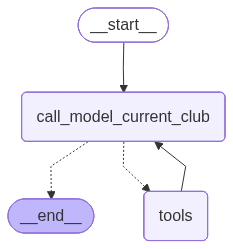

In [4]:
from langgraph.prebuilt import ToolNode
current_club_graph = StateGraph(
    state_schema=OverallState,
    input_schema=InputState,
    output_schema=OutputState
)


current_club_graph.add_node("call_model_current_club", call_model_current_club)
current_club_graph.add_node("tools", ToolNode(tools))

current_club_graph.add_edge(START, "call_model_current_club")
current_club_graph.add_conditional_edges("call_model_current_club", should_continue)
current_club_graph.add_edge("tools", "call_model_current_club")

current_club_researcher = current_club_graph.compile()

current_club_researcher

In [5]:
initial_agent = {"article": "Thomas Muller will join Real Madrid in 2025."}
current_club_researcher.invoke(initial_agent)

{'agent_output': 'Current club information not available.'}

## Market Value Researcher

In [19]:
class InputState(TypedDict):
    article: str


class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]



@tool
def get_market_value(player_name: str):
    """Gets current market value of a player"""
    db = {
        "Lionel Messi": "50 Mil Euros",
        "Cristiano Ronaldo": "30 Mil Euros"
    }

    return db.get(player_name, "Market Value information not available.")


tools2 = [get_market_value]
model2 = llm.bind_tools(tools2)
model2

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B78D611070>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B78D38CDD0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_market_value', 'description': 'Gets current market value of a player', 'parameters': {'properties': {'player_name': {'type': 'string'}}, 'required': ['player_name'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [23]:
def call_model_market_value(state: OverallState):
    local_messages = state.get("messages", [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)
    system_message = SystemMessage(content="""You are an agent tasked with determining the market value of a player. If the market value is mentioned, return it. Otherwise, return 'Market value information not available.'""")
    response = model2.invoke([system_message] + local_messages)
    print(f"Response: {response}")
    state['agent_output'] = response.content
    state['messages'] = local_messages + [response]
    return state

def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, "tools_calls", None):
        return "tools"
    return END

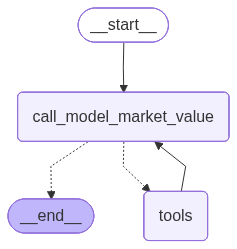

In [24]:
market_value_graph = StateGraph(
    state_schema=OverallState,
    input_schema=InputState,
    output_schema=OutputState
)

market_value_graph.add_node("call_model_market_value", call_model_market_value)
market_value_graph.add_node("tools", ToolNode(tools2))

market_value_graph.add_edge(START, "call_model_market_value")
market_value_graph.add_conditional_edges("call_model_market_value", should_continue)
market_value_graph.add_edge("tools", "call_model_market_value")

market_value_researcher = market_value_graph.compile()
market_value_researcher

In [25]:
market_value_researcher.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

Response: content='' additional_kwargs={'tool_calls': [{'id': '8vez1jqn2', 'function': {'arguments': '{"player_name":"Lionel Messi"}', 'name': 'get_market_value'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 176, 'total_tokens': 309, 'completion_time': 0.514450884, 'prompt_time': 0.024639689, 'queue_time': 0.04398314, 'total_time': 0.539090573}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f30771e6-eff9-4c9d-9809-335751176b4c-0' tool_calls=[{'name': 'get_market_value', 'args': {'player_name': 'Lionel Messi'}, 'id': '8vez1jqn2', 'type': 'tool_call'}] usage_metadata={'input_tokens': 176, 'output_tokens': 133, 'total_tokens': 309}


{'agent_output': ''}

In [27]:
market_value_researcher.invoke({"article": "market value of Cristiano Ronaldo"})

Response: content='The market value of Cristiano Ronaldo, as of the latest available data, is estimated to be around €20 million.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 558, 'prompt_tokens': 165, 'total_tokens': 723, 'completion_time': 2.183386866, 'prompt_time': 0.027262209, 'queue_time': 0.045647561, 'total_time': 2.210649075}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--e32a0862-34cb-4f83-8487-f653c60d27f6-0' usage_metadata={'input_tokens': 165, 'output_tokens': 558, 'total_tokens': 723}


{'agent_output': 'The market value of Cristiano Ronaldo, as of the latest available data, is estimated to be around €20 million.'}

In [28]:
market_value_researcher.invoke({"article": "market value of Lionel Messi"})

Response: content='' additional_kwargs={'tool_calls': [{'id': 'ky34jh5q8', 'function': {'arguments': '{"player_name":"Lionel Messi"}', 'name': 'get_market_value'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 165, 'total_tokens': 429, 'completion_time': 1.159860393, 'prompt_time': 0.024004355, 'queue_time': 0.046297614, 'total_time': 1.183864748}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--e8a42cd5-c1a8-42dc-9a8d-1edd6443a9a2-0' tool_calls=[{'name': 'get_market_value', 'args': {'player_name': 'Lionel Messi'}, 'id': 'ky34jh5q8', 'type': 'tool_call'}] usage_metadata={'input_tokens': 165, 'output_tokens': 264, 'total_tokens': 429}


{'agent_output': ''}

## Text Writer Agent

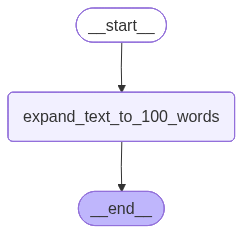

In [31]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    pass


def expand_text_to_100_words(state: OverallState):
    human_message = HumanMessage(content=state['article'])
    system_message = SystemMessage(content="Expand the following text to be at least 100 words. maintain the original meaning while adding detail.")
    response = llm.invoke([system_message, human_message])
    state['agent_output'] = response.content
    return state

text_writer_graph = StateGraph(
    state_schema=OverallState,
    input_schema=InputState,
    output_schema=OutputState
)

text_writer_graph.add_node("expand_text_to_100_words", expand_text_to_100_words)

text_writer_graph.add_edge(START, "expand_text_to_100_words")
text_writer_graph.add_edge("expand_text_to_100_words", END)


text_writer_agent = text_writer_graph.compile()

text_writer_agent

In [33]:
res = text_writer_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})
res

{'agent_output': "<think>\nAlright, so the user wants me to expand a given text to at least 100 words while keeping the original meaning and adding more details. The text is about Lionel Messi moving from FC Barcelona to Real Madrid in 2025.\n\nHmm, first, I need to understand the original statement. It's pretty straightforward, but I have to add more depth. Maybe talk about the implications of such a move. Messi has been a symbol for Barcelona, so switching to Real Madrid would be a big deal.\n\nI should mention his history with Barcelona, like how long he's been there and his achievements. That will highlight why this move is significant. Also, the rivalry between the two clubs is famous, so that's a good point to include.\n\nI wonder about the reaction of the fans. Both sets of fans might have strong opinions. Barcelona fans might be upset, while Real Madrid fans would be excited. Including that emotional aspect could add depth.\n\nWhat about the reasons behind the move? Maybe finan

In [39]:
print(res['agent_output'][res['agent_output'].find("</think>") + len("</think>"):].strip())

Lionel Messi's decision to leave FC Barcelona and join Real Madrid in 2025 has sent shockwaves through the football world. Messi, widely regarded as one of the greatest players of all time, has spent the majority of his career at Barcelona, where he has won numerous accolades, including multiple Ballon d'Or awards and Champions League titles. His move to Real Madrid, Barcelona's fiercest rival, marks a dramatic shift in his career trajectory. The transfer is expected to be one of the most high-profile in football history, sparking intense debate among fans and analysts alike. While the exact terms of the deal remain undisclosed, speculation surrounds the financial and personal reasons behind Messi's decision. For Barcelona, losing their iconic star will be a significant blow, while Real Madrid will gain a legendary talent aiming to extend his legacy. The move is set to reshape the dynamics of Spanish football and ignite a new chapter in the storied El Clásico rivalry.


# Supervisor Agent

In [41]:
from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

class ArticlePostabilityGrader(BaseModel):
    """Binary scores for verifying if an article mentions market value, current club, \
        and meets the minimum word count of 100 words."""
    
    off_or_on_topic: str = Field(description="The article is about football transfers, 'yes' or 'no'")
    mentions_market_value: str = Field(description="The article mentions the player's market value, 'yes' or 'no'")
    mentions_current_club: str = Field(description="The article mentions the player's current club, 'yes' or 'no'")
    meets_100_words: str = Field(description="The article has at least 100 words, 'yes' or 'no'")



structured_llm_postability_grader = llm.with_structured_output(ArticlePostabilityGrader)

postability_system = """
You are a grader assessing whether a news article meets the following criteria:
1. The article is about football transfers or not. If yes answer, answer with 'yes', otherwise with 'no'.
2. The article explicitly mentions the player's market value, for example, by stating 'market value' or a specific currency\
amount (e.g., "$50 million"). If this is present, respond with 'yes' for mentions_market_value; otherwise, respond 'no'.
3. The article mentions the player's current club or indicates that the current club information is unavailable \
(e.g., "Current Club information is not available"). If this is present, respond with 'yes' for mentions_current_club; \
otherwise, respond 'no'.
4. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.


Provide four binary scores ('yes' or 'no') as follows:
- off_or_on_topic: 'yes' or 'no' depending on whether the article is related to football transfers or not.
- mentions_market_value: 'yes' or 'no' depending on whether the article mentions the player's market value.
- mentions_current_club: 'yes' or 'no' depending on whether the article mentions the player's current club or states that \
the information is unavailable.
- meets_100_words: 'yes' or 'no' depending on whether the article has at least 100 words.
"""

print(postability_system)


You are a grader assessing whether a news article meets the following criteria:
1. The article is about football transfers or not. If yes answer, answer with 'yes', otherwise with 'no'.
2. The article explicitly mentions the player's market value, for example, by stating 'market value' or a specific currencyamount (e.g., "$50 million"). If this is present, respond with 'yes' for mentions_market_value; otherwise, respond 'no'.
3. The article mentions the player's current club or indicates that the current club information is unavailable (e.g., "Current Club information is not available"). If this is present, respond with 'yes' for mentions_current_club; otherwise, respond 'no'.
4. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.


Provide four binary scores ('yes' or 'no') as follows:
- off_or_on_topic: 'yes' or 'no' depending on whether the article is related to football transfers or not.
- mentions_market_value:

In [43]:
postability_grade_prompt =  ChatPromptTemplate.from_messages(
    [
        ("system", postability_system),
        ("human", "News Article:\n\n{article}")
    ]
)
print(postability_grade_prompt)

input_variables=['article'] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\nYou are a grader assessing whether a news article meets the following criteria:\n1. The article is about football transfers or not. If yes answer, answer with \'yes\', otherwise with \'no\'.\n2. The article explicitly mentions the player\'s market value, for example, by stating \'market value\' or a specific currencyamount (e.g., "$50 million"). If this is present, respond with \'yes\' for mentions_market_value; otherwise, respond \'no\'.\n3. The article mentions the player\'s current club or indicates that the current club information is unavailable (e.g., "Current Club information is not available"). If this is present, respond with \'yes\' for mentions_current_club; otherwise, respond \'no\'.\n4. The article contains at least 100 words. If this is met, respond with \'yes\' for meets_100_words

In [45]:
news_chef = postability_grade_prompt | structured_llm_postability_grader
r1 = news_chef.invoke({'article': "Lionel Messi will switch to Real Madrid in 2025"})
r1

ArticlePostabilityGrader(off_or_on_topic='yes', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

In [47]:
print(r1)

off_or_on_topic='yes' mentions_market_value='no' mentions_current_club='no' meets_100_words='no'


In [46]:
r2 = news_chef.invoke({'article': "Today in Bengaluru will be 10 Deg C"})
r2

ArticlePostabilityGrader(off_or_on_topic='no', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

In [48]:
print(r2)

off_or_on_topic='no' mentions_market_value='no' mentions_current_club='no' meets_100_words='no'


# Workflow

In [50]:
from typing import Literal, TypedDict
from langgraph.graph import END, StateGraph

class InputArticleState(TypedDict):
    article: str

class OutputFinalArticleState(TypedDict):
    final_article: str
    off_or_on_topic: str

class SharedArticleState(InputArticleState, OutputFinalArticleState):
    mentions_market_value: str
    mentions_current_club: str
    meets_100_words: str



def update_article_state(state: SharedArticleState) -> SharedArticleState:
    response = news_chef.invoke({"article": state['article']})
    state['off_or_on_topic'] = response.off_or_on_topic
    state['mentions_market_value'] = response.mentions_market_value
    state['mentions_current_club'] = response.mentions_current_club
    state['meets_100_words'] = response.meets_100_words

    print(f"State after update_article_state: {state}")

    return state

def market_value_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = market_value_researcher.invoke({"article": state["article"]})
    state['article'] += f"{response['agent_output']}"
    return state

def current_club_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = current_club_researcher.invoke({"article": state['article']})
    state['article'] += f"{response["agent_output"]}"
    return state

def word_count_rewriter_node(state: SharedArticleState) -> SharedArticleState:
    response = text_writer_agent.invoke({"article": state['article']})
    state['article'] += f"{response['agent_output']}"
    return state

def news_chef_decider(state: SharedArticleState) -> Literal[
    "market_value_researcher", "current_club_researcher", "text_writer_agent"
]:
    if state['off_or_on_topic'] == "no":
        return END
    if state['mentions_market_value'] == "no":
        return "market_value_researcher"
    elif state['mentions_current_club'] == "no":
        return "current_club_researcher"
    elif(
        state['meets_100_words'] == "no" and 
        state['mentions_market_value'] == "yes" and
        state['mentions_current_club'] == "yes"
    ):
        return "word_count_rewriter"
    else:
        return END

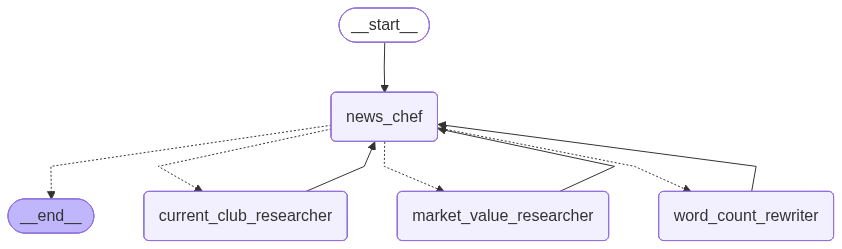

In [52]:
workflow = StateGraph(
    state_schema=SharedArticleState,
    input_schema=InputArticleState,
    output_schema=OutputFinalArticleState
)

workflow.add_node("news_chef", update_article_state)
workflow.add_node("market_value_researcher", market_value_researcher)
workflow.add_node("current_club_researcher", current_club_researcher_node)
workflow.add_node("word_count_rewriter", word_count_rewriter_node)

workflow.set_entry_point("news_chef")

workflow.add_conditional_edges(
    "news_chef",
    news_chef_decider,
    {
        "market_value_researcher": "market_value_researcher",
        "current_club_researcher": "current_club_researcher",
        "word_count_rewriter": "word_count_rewriter",
        END: END
    },
)

workflow.add_edge("market_value_researcher", "news_chef")
workflow.add_edge("current_club_researcher", "news_chef")
workflow.add_edge("word_count_rewriter", "news_chef")

app = workflow.compile()
app

In [53]:
r1 = app.invoke({"article": "Today in Bengaluru will be 15 deg C"})
r1

State after update_article_state: {'article': 'Today in Bengaluru will be 15 deg C', 'off_or_on_topic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


{'off_or_on_topic': 'no'}

In [54]:
r1 = app.invoke({"article": "Lionel Messi will move to Real Madrid in 2025"})
r1

State after update_article_state: {'article': 'Lionel Messi will move to Real Madrid in 2025', 'off_or_on_topic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
Response: content='' additional_kwargs={'tool_calls': [{'id': 'h3tn9vykz', 'function': {'arguments': '{"player_name":"Lionel Messi"}', 'name': 'get_market_value'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 173, 'total_tokens': 354, 'completion_time': 0.662933718, 'prompt_time': 0.036778049, 'queue_time': 0.049993341, 'total_time': 0.699711767}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--30b62456-191f-47cb-b937-1e7386cec444-0' tool_calls=[{'name': 'get_market_value', 'args': {'player_name': 'Lionel Messi'}, 'id': 'h3tn9vykz', 'type': 'tool_call'}] usage_metadata={'input_tokens': 173, 'output_tokens': 181, 'total_tokens': 354}


KeyboardInterrupt: 

# Add Human in the loop

In [55]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()


class InputState(TypedDict):
    question: str

class IntermediateState(InputState):
    off_or_on_topic: str
    answer: str

class FinalState(IntermediateState):
    api_response: str
    status_code: int

In [57]:
def input_node(state: InputState) -> InputState:
    return state

def newsagent_node(state: IntermediateState) -> IntermediateState:
    response = app.invoke({"article": state['question']})
    state['answer'] = response.get("final_article", "Article not relevant for news agency.")
    state['off_or_on_topic'] = response['off_or_on_topic']
    return state

def api_call_node(state: FinalState) -> FinalState:
    state['status_code'] = 200
    state['api_response'] = f"API received answer: {state['answer']}"
    return state

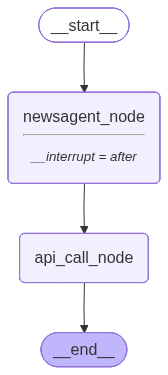

In [58]:
updated_workflow = StateGraph(FinalState, input=InputState, output=FinalState)

updated_workflow.add_node("newsagent_node", newsagent_node)
updated_workflow.add_node("api_call_node", api_call_node)

updated_workflow.set_entry_point("newsagent_node")

updated_workflow.add_edge("newsagent_node", "api_call_node")
updated_workflow.add_edge("api_call_node", END)

human_app = updated_workflow.compile(checkpointer=checkpointer, interrupt_after=['newsagent_node'])
human_app

In [59]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [60]:
human_app.invoke({'question': "The weather will be 15deg C in Bengaluru"}, config=config2, subgraphs=True)

State after update_article_state: {'article': 'The weather will be 15deg C in Bengaluru', 'off_or_on_topic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


{'question': 'The weather will be 15deg C in Bengaluru',
 'off_or_on_topic': 'no',
 'answer': 'Article not relevant for news agency.'}

In [ ]:
human_app.invoke({'question': "Lionel Messi will move to Real Madrid in 2025"}, config=config1, subgraphs=True)

State after update_article_state: {'article': 'Lionel Messi will move to Real Madrid in 2025', 'off_or_on_topic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
Response: content='Market value information not available.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 173, 'total_tokens': 326, 'completion_time': 0.778326687, 'prompt_time': 0.029001013, 'queue_time': 0.050063797, 'total_time': 0.8073277}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--691ed0dd-6efd-4663-8fb3-ec60dee27838-0' usage_metadata={'input_tokens': 173, 'output_tokens': 153, 'total_tokens': 326}
State after update_article_state: {'article': 'Lionel Messi will move to Real Madrid in 2025', 'off_or_on_topic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
Response: content='' additio

In [ ]:
snapshot = human_app.get_state(config2)
snapshot.next

In [ ]:
human_app.invoke(None, config=config2)

In [ ]:
snapshot = human_app.get_state(config1)
snapshot.next

In [ ]:
snapshot = human_app.get_state(config1)
existing_message = snapshot.values
existing_message

In [ ]:
human_app.update_state(config1, {"answer": "Fake news!!!"})

In [ ]:
human_app.invoke(None, config=config1)

In [ ]:
snapshot = human_app.get_state(config1)
snapshot.next